# LB05 & LB06 Multilayer Perceptron

In this lecture, you are going to apply the knowledge you acquired during this course. Your goal is to fully configure, train and evaluate a Multilayer Perceptron that classifies images of handwritten digits from the [MNIST](http://yann.lecun.com/exdb/mnist/) database.

In the link provided, you find a detailed description of the dataset as well as a table containing error rates of classifiers that were previously trained by other researchers.

<center><img src="resources/LB05_MNIST.png" style="width: 75%"/></center>
<center><a href="https://towardsdatascience.com/improving-accuracy-on-mnist-using-data-augmentation-b5c38eb5a903">towardsdatascience.com</a></center>


The images in the large [MNIST](http://yann.lecun.com/exdb/mnist/) dataset are 28x28 pixels. To simplify the task a bit, we will use downscaled images (8x8).

We challenge you to build a classifier based on the concept of Multilayer Perceptron that comes close to the error rates stated in the aforementioned table.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline 
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, learning_curve, StratifiedKFold
import os, keras
from sklearn.datasets import load_digits
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

Using TensorFlow backend.


In [2]:
# function adapted from https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html
# we adapted the code to introduce our own scoring (using binary-crossentropy loss) specifically for keras models

def custom_learning_curve(model, X, y, n_folds = 10, train_sizes = np.linspace(0.1, 1, 10)):
    """
    Learning curve.
    Determines cross-validated training and test scores for different training
    set sizes.
    
    A cross-validation generator splits the whole dataset k times in training
    and test data. Subsets of the training set with varying sizes will be used
    to train the estimator and a score for each training subset size and the
    test set will be computed. Afterwards, the scores will be averaged over
    all k runs for each training subset size.
    
    Returns (adapted by reufko & mschirl):
    -------
    train_counts : array of shape (train_sizes,) holding the average number of samples used to train the model

    train_losses : array of shape (n_folds, train_sizes) holding the train losses computed for each fold and train_size

    valid_losses : array of shape (n_folds, train_sizes) holding the validation losses computed for each fold and train_size 
    """
    
    model.save_weights('initial_weights.h5')
    kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=None)
    train_losses = []
    valid_losses = []
    train_counts = []
    
    for train, valid in kfold.split(X, y.argmax(1)):
        train_loss = []
        valid_loss = []
        train_count = []
        for percentage in train_sizes:
            if percentage == 1.0:
                X_train, y_train = (X[train, :], y[train])
            else:
                X_train, X_test, y_train, y_test = train_test_split(X[train, :], y[train], test_size=1-percentage, random_state = None)
            history = model.fit(X_train, y_train, epochs=200, verbose=0)
            train_loss.append(model.evaluate(X_train, y_train, verbose=0)[0])
            valid_loss.append(model.evaluate(X[valid, :], y[valid], verbose=0)[0])
            model.load_weights('initial_weights.h5')
            train_count.append(X_train.shape[0])
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        train_counts.append(train_count)
    os.remove("initial_weights.h5")
    return np.array(train_counts).T.mean(axis=1), np.array(train_losses).T, np.array(valid_losses).T

In [3]:
# This function returns the index of an epoch where early stopping (based patience and epsilon) should be performed.
def get_early_stopping_index(history, patience=5, epsi = 0.0001):
  counter = 0
  max_loss = np.array(history["val_loss"]).max()
  i=0

  for index, row in enumerate(history["val_loss"]):
    if(counter==patience):
      break

    if(row<max_loss-epsi):
      i=index
      max_loss=row
      counter = 0
    else:
      counter+=1
      
  return i

In [4]:
def plot_learning_curve(estimator, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5), scoring=None, title=""):
    # Function taken from
    # https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure(figsize=(12, 5))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Loss")
    train_sizes, train_scores, test_scores = custom_learning_curve(estimator, X, y, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training loss")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation loss")

    plt.legend(loc="best")
    return plt

In [5]:
# Simple function that plots loss over epochs and accuracy over epochs (for both train and validation set).
# Also adds a marker for the epoch, where early stopping should be performed if the appropriate index is passed
def plot_learning_curve_over_epochs(history = None, early_stopping = None):
    fig = plt.figure(figsize=(12, 10), dpi=80)
    plt.subplot(2, 1, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss Curves')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train Loss', 'Validation Loss'], loc='best')
    if early_stopping:
        plt.axvline(x=early_stopping+1, color='r', linestyle='-', label="Early Stopping: "+str(early_stopping+1))
    
    
    plt.subplot(2, 1, 2)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Accuracy Curves')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train Accuracy', 'Validation Accuracy'], loc='best')
    if early_stopping:
        plt.axvline(x=early_stopping+1, color='r', linestyle='-', label="Early Stopping: "+str(early_stopping+1))
    
    plt.show()

## LB05 Full configuration, training and evaluation of a MLP

At the start of this section, we already the necessary data loading functions for you. After that, you will be on your own.

You may need the official documentation of [Keras](https://keras.io/api/) and [tensorflow](https://www.tensorflow.org/versions)  to complete the tasks below. This is why the cell below will print your current Keras and tensorflow version for you, to make it easier for you to find matching documentation files.

In [10]:
import keras as k
import tensorflow as tf
print('Keras: {:s}'.format(k.__version__))
print('tensorflow: {:s}'.format(tf.__version__))

Keras: 2.3.1
tensorflow: 2.1.0


### LB05.1 Loading and preprocessing the MNIST dataset
The data needed for this excercise is being loaded and plotted in the cell bellow.

Number of Samples: 1797


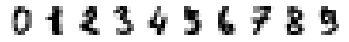

In [6]:
# load the input dataset
digits = load_digits()
X, y = digits.data, digits.target

# print sample size
sample_size = len(X)
print("Number of Samples: %i" % sample_size)

# display the first digits
num_digits = 10
digits_display = digits.images[0:num_digits]

for i,image in enumerate(digits_display):
    plt.subplot(1, num_digits, i+1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')

### LB05.1 a) Data Preparation
Now that you have your data set, perform all necessary steps to be able to train your model.

### LB05.2 Configure a baseline ANN

After loading and preparing the dataset, you are now ready to configure, train and evaluate your MLP.
The first configuration will (most likely) lead to a baseline neural network that you will try to improve in later tasks.

### LB05.2 a) Model creation
Define the following:
- input dimensionality, 
- output dimensionality, 
- number of layers you want to use (**be sure to use 3 hidden layers at most**), 
- number of nodes for each layer,
- transfer functions of the hidden layers and the output layer.

### LB05.2 b) Model compilation
- Be sure to define an optimizer & an appropriate loss function.
- Compile and plot the number of trainable parameters (`model.summary()`).

### LB05.2 c) Fit the model

Fit the created model with an appropriate number of epochs and batch size.

### LB05.2 d) Evaluation
- Evaluate the model's training progress using the learning curve functions provided.

- Be aware of the fact, that since this model's complexity is higher than the complexity of the models we trained in the last classes, the function `plot_learning_curve()` will take some time to run. You can stick with the `plot_learning_curve_over_epochs()` during the lesson and use the other function if you have enough time at home.
- Plot a confusion matrix as well as the overall accuracy. Also document precision and recall for each class. If you want to be able to compare your model's performance to the classifiers in the [MNIST](http://yann.lecun.com/exdb/mnist/) table, you may want to calculate the error rate too.

### LB05.3 Change the model capacity of your baseline ANN
This task aims to help you find an appropriate model architecture that is neither too complex nor too simple (bias vs. variance tradeoff).

### LB05.3 a) Choosing appropriate model complexity
- Add or remove hidden layers, change the number of neurons for each hidden layer.
- Leave the rest of the parameters the same as in the baseline.
- Calculate the number of trainable parameters for your model.

### LB05.3 b) Training and evaluation
Repeat the steps from LB05.2 c) and LB05.2 d) for the newly created model.

### LB05.4 Experiment with optimizers, learning rates and epochs as well as batch sizes

Now that you found a model complexity that is neither too high nor too simple, you are going to try out different optimizers and optimizers. In a later step, you will alter the training time as well as the number of samples that are contained in a single batch to further improve training performance.


### LB05.4 a) Optimizer
Try out different optimizers for this problem. Which one works best for you? Document your results by plotting learning curves and evaluating your model's performance.

### LB05.4 b) Learning rates
Once you found an appropriate optimizer, try different learning rates.

**Question**: What happens to the learning curve of your model when high (<=0.1) and low (>$10^{-8}$) learning rates are chosen?

### LB05.4 c) Epochs and batch sizes
Find a combination of epochs and batch size that is suitable. 

**Question**: What happens if the batch size is larger than the number of samples in `X_train`?

### LB05.4 d) Training and evaluation
Repeat the steps from LB05.2 c) and LB05.2 d) for the newly created model. Document your findings!

### LB05.5 Improve your model's generalization capabilities (by preventing overfitting)
As a last step that aims to improve your model, you are going to introduce regularization as well as early stopping. These techniques may help you to prevent potential overfitting.

### LB05.5 a) Regularization
Add regularization to your hidden layers. The type of regularization and the weights you regularize are up to you. Experiment with different values for the regularization parameter $\lambda$.

**Question**: What happens if you choose high values for $\lambda$?

### LB05.5 b) Early Stopping
Finally, add the `EarlyStopping` callback to your model's `fit()` method with approriate values for epsilon and patience.

**Question**: Is there a default value for epsilon that you may stick to when using `EarlyStopping`?  Also, explain the relationship between loss function, patience and epsilon.

### LB05.6 Final evaluation
The optimizations in LB05.5 should help to improve your model's ability to learn a generalization of its input dataset. Repeat the steps from LB05.2 c) and LB05.2 d) for the newly created model to verify this hypothesis.

### LB05.6 a) Were you successful in improving your model when compared to the baseline? Document your results.

Depending on your result, you may also want to compare your model's performance to the classifiers listed in the [MNIST](http://yann.lecun.com/exdb/mnist/) table.

### LB06 Questions

To conclude this lession, we want you to answer a few questions that may also help you when preparing for your exam in machine learning. 

**Q1:** You printed the number of trainable parameters in earlier tasks. What are the trainable parameters in a multilayer perceptron?

**Q2:** What is the difference between gradient descent and stochastic gradient descent?

**Q3:** What properties does "Adam" combine and how is it different from SGD?

**Q4:** What is the purpose of "momentum" in gradient based optimization?

**Q5:** What is a possible consequence if an insufficient number of neurons is chosen in your model?

**Q6:** What is a possible consequence if an excessive number of neurons is chosen in your model?

**Q7:** Why do we care about regularization?

**Q8:** What is the "vanishing gradient" problem?